In [1]:
import matplotlib.pyplot as plt
import numpy as np

import json

from scipy.signal import savgol_filter

In [2]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
    !pyomo build-extensions

In [265]:
from pyomo.environ import *
from pyomo.dae import *
import idaes

np.random.seed(0)

## Data preprocessing

In [561]:
f = open('../../data/TAP_thin_data.json')
thin_data = json.load(f)
f.close()
thin_data = json.loads(thin_data)['1']

np.random.seed(0)

n_species = 0

conc_train = []
t = []

# Include 5-pulse in training
pulse_train = ['0', '1', '2', '3', '4']

# Subsampling and add noise
for j, k in enumerate(thin_data):
    if k == 'time':
        for i in thin_data[k].keys():
            if i in pulse_train:
                t_temp = thin_data[k][i][14:40:1]
                t_temp += thin_data[k][i][40:100:10]
                t_temp += thin_data[k][i][100:300:50]
                t_temp += thin_data[k][i][300::100]
                t_temp = np.array(t_temp) + 2.5*(int(i))
                t += list(t_temp)
    elif k =='Ar':
        continue
    else:
        y_temp_train = []
        for i in thin_data[k].keys():
            y_temp_i = []
            if i in pulse_train:
                y_temp_i = thin_data[k][i][14:40:1] + thin_data[k][i][40:100:10] + thin_data[k][i][100:300:50] + thin_data[k][i][300::100]
                noise = np.std(np.array(y_temp_i)) * 2.0
                y_yemp_i = list(np.array(y_temp_i) + np.random.normal(0.0, noise, np.array(y_temp_i).shape))
            
                y_temp_train += y_yemp_i
        conc_train.append(np.array(y_temp_train))

y = np.array(conc_train)

# y_smooth = []
# for i in range(len(y)):
#     y_smooth.append(savgol_filter(y.T[:,i], 11, 2))
# y = np.array(y_smooth)

data = {i:{t[j]:value[j] for j in range(len(value))} for i, value in enumerate(y)}

In [568]:
def read_flux(file_name):
    '''Read the flux output file from TAPSolver'''

    f_path = file_name
    f = open(f_path)
    flux_data = json.load(f)
    f.close()
    flux_data = json.loads(flux_data)['1']

    y = []
    for j, k in enumerate(flux_data):
        if k == 'time':
            continue
        elif k == 'Ar':
            continue
        else:
            y_temp_train = []
            for i in thin_data[k].keys():
                if i in pulse_train:
                    y_temp_train += flux_data[k][i][14:40:1]
                    y_temp_train += flux_data[k][i][40:100:10]
                    y_temp_train += flux_data[k][i][100:300:50]
                    y_temp_train += flux_data[k][i][300::100]
            y.append(np.array(y_temp_train))

    y = np.array(y).T
    flux = (y, t)

    return flux

flux_in = read_flux('../../data/TAP_cat_in.json')
flux_out = read_flux('../../data/TAP_cat_out.json')

L_thin = 0.17364

net_flux = (flux_in[0] - flux_out[0])/L_thin
F_data = {i:{t[j]:value[j] for j in range(len(value))} for i, value in enumerate(net_flux.T)}

## Pyomo.dae simulation

In [570]:
%%time

m = ConcreteModel()
m.t = ContinuousSet(initialize=t)
m.t_meas = Set(initialize=t)

# Define ground truth training data
m.CO_meas  = Param(m.t_meas, initialize=data[0])
m.O2_meas  = Param(m.t_meas, initialize=data[1])
m.CO2_meas = Param(m.t_meas, initialize=data[2])
m.COs_meas = Param(m.t_meas, initialize=data[3])
m.Os_meas  = Param(m.t_meas, initialize=data[4])
m.s_meas   = Param(m.t_meas, initialize=data[5])

# Define net flux for gas species
m.CO_F_meas  = Param(m.t_meas, initialize=F_data[0])
m.O2_F_meas  = Param(m.t_meas, initialize=F_data[1])
m.CO2_F_meas = Param(m.t_meas, initialize=F_data[2])

# Initialize net flux
m.CO_F  = Var(m.t, initialize=F_data[0])
m.O2_F  = Var(m.t, initialize=F_data[1])
m.CO2_F = Var(m.t, initialize=F_data[2])

# Define concentration terms
m.CO  = Var(m.t, within=NonNegativeReals)
m.O2  = Var(m.t, within=NonNegativeReals)
m.CO2 = Var(m.t, within=NonNegativeReals)
m.COs = Var(m.t, within=NonNegativeReals)
m.Os  = Var(m.t, within=NonNegativeReals)
m.s   = Var(m.t, within=NonNegativeReals)

# Initialize kinetic parameters
m.k1  = Var(initialize = 1e-5, within=PositiveReals)
m.k1_ = Var(initialize = 1e-5, within=PositiveReals)
m.k2  = Var(initialize = 1e-5, within=PositiveReals)
m.k3  = Var(initialize = 1e-5, within=PositiveReals)
m.k3_ = Var(initialize = 1e-5, within=PositiveReals)
m.k4  = Var(initialize = 1e-5, within=PositiveReals)

# Define rates/derivative terms dC/dt
m.dCO  = DerivativeVar(m.CO,  wrt=m.t)
m.dO2  = DerivativeVar(m.O2,  wrt=m.t)
m.dCO2 = DerivativeVar(m.CO2, wrt=m.t)
m.dCOs = DerivativeVar(m.COs, wrt=m.t)
m.dOs  = DerivativeVar(m.Os,  wrt=m.t)
m.ds   = DerivativeVar(m.s,   wrt=m.t)

# Define initial conditions
def _init_conditions(m):
    yield m.CO[0.005]  == 1e-5
    yield m.O2[0.005]  == 1e-5
    yield m.CO2[0.005] == 1e-5
    yield m.COs[0.005] == 1e-5
    yield m.Os[0.005]  == 1e-5
    yield m.s[0.005]   == 30.0
m.init_conditions=ConstraintList(rule=_init_conditions)

# Define the kinetic models as function of concentration and flux
def _dCO(m,i):
    if i==0.005:
        return Constraint.Skip
    return m.dCO[i] == - m.k1*m.CO[i]*m.s[i] + m.k1_*m.COs[i] - m.k4*m.CO[i]*m.Os[i] + m.CO_F[i]
m.dCOcon = Constraint(m.t, rule=_dCO)

def _dO2(m,i):
    if i==0.005:
        return Constraint.Skip
    return m.dO2[i] == - m.k2*m.O2[i]*m.s[i]**2 + m.O2_F[i]
m.dO2con = Constraint(m.t, rule=_dO2)

def _dCO2(m,i):
    if i==0.005:
        return Constraint.Skip
    return m.dCO2[i] == m.k3*m.COs[i]*m.Os[i] - m.k3_*m.CO2[i]*m.s[i]**2 + m.k4*m.CO[i]*m.Os[i] + m.CO2_F[i]
m.dCO2con = Constraint(m.t, rule=_dCO2)

def _dCOs(m,i):
    if i==0.005:
        return Constraint.Skip
    return m.dCOs[i] == m.k1*m.CO[i]*m.s[i] - m.k1_*m.COs[i] - m.k3*m.COs[i]*m.Os[i] + m.k3_*m.CO2[i]*m.s[i]**2
m.dCOscon = Constraint(m.t, rule=_dCOs)

def _dOs(m,i):
    if i==0.005:
        return Constraint.Skip
    return m.dOs[i] == (m.k2*m.O2[i]*m.s[i]**2)*2 - m.k3*m.COs[i]*m.Os[i] + m.k3_*m.CO2[i]*m.s[i]**2 - m.k4*m.CO[i]*m.Os[i]
m.dOscon = Constraint(m.t, rule=_dOs)

def _ds(m,i):
    if i==0.005:
        return Constraint.Skip
    return m.ds[i] == -m.k1*m.CO[i]*m.s[i] + m.k1_*m.COs[i] - (m.k2*m.O2[i]*m.s[i]**2)*2 + m.k3*m.COs[i]*m.Os[i]*2 - 2*m.k3_*m.CO2[i]*m.s[i]**2 + m.k4*m.CO[i]*m.Os[i]
m.dscon = Constraint(m.t, rule=_ds)

# Define objective function to minimize the difference between the concentration
# Objective function is normalized using the mean concentration value of each species
and flux value and the ground truth
def _obj(m):
    sum1 = sum((m.CO[i]    -    m.CO_meas[i])**2 for i in m.t_meas if i in m.CO_meas.keys())/0.008
    sum2 = sum((m.O2[i]    -    m.O2_meas[i])**2 for i in m.t_meas if i in m.O2_meas.keys()) /0.0106
    sum3 = sum((m.CO2[i]   -   m.CO2_meas[i])**2 for i in m.t_meas if i in m.CO2_meas.keys()) /0.00653
    sum4 = sum((m.COs[i]   -   m.COs_meas[i])**2 for i in m.t_meas if i in m.COs_meas.keys())/0.407
    sum5 = sum((m.Os[i]    -    m.Os_meas[i])**2 for i in m.t_meas if i in m.Os_meas.keys()) /3.898
    sum6 = sum((m.s[i]     -     m.s_meas[i])**2 for i in m.t_meas if i in m.s_meas.keys()) /25.65
    sum7 = sum((m.CO_F[i]  -  m.CO_F_meas[i])**2 for i in m.t_meas if i in m.CO_F_meas.keys()) /2.6
    sum8 = sum((m.O2_F[i]  -  m.O2_F_meas[i])**2 for i in m.t_meas if i in m.O2_F_meas.keys()) /1.9
    sum9 = sum((m.CO2_F[i] - m.CO2_F_meas[i])**2 for i in m.t_meas if i in m.CO2_F_meas.keys()) /0.68
    return sum1+sum2+sum3+sum4+sum5+sum6+sum7+sum8+sum9
m.obj = Objective(rule=_obj, sense = minimize)


instance = m.create_instance()

discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(instance, nfe=30, ncp=1)

solver=SolverFactory('ipopt')
solver.options['max_iter'] = 500000 
results = solver.solve(instance,tee=True)

of finite elements specified in apply. The larger number of finite elements
will be used.
Ipopt 3.14.12: max_iter=500000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    22350
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     7359

Total number of variables............................:     4425
                     variables with only lower bounds:     1776
                variables with lower and upper bounds:        0
                     variables wit

  76  4.5766383e+04 2.85e-02 1.88e+03  -1.0 1.91e-01   2.2 8.60e-01 1.00e+00f  1
  77  4.0748682e+04 1.04e-01 6.34e+02  -1.0 5.31e-01   1.7 9.98e-01 1.00e+00f  1
  78  3.0101866e+04 2.27e-01 7.05e+02  -1.0 1.31e+00   1.2 9.91e-01 1.00e+00f  1
  79  1.5528283e+04 5.48e-01 1.83e+03  -1.0 2.40e+00   0.7 4.52e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  7.5660449e+03 7.13e-01 5.01e+02  -1.0 2.51e+00   0.3 4.37e-01 8.10e-01f  1
  81  4.6104204e+03 6.01e-01 2.41e+02  -1.0 3.56e+00  -0.2 7.23e-01 5.46e-01f  1
  82  1.5625481e+03 4.71e+00 1.03e+03  -1.0 6.12e+00  -0.7 2.77e-01 8.62e-01f  1
  83  1.3918115e+03 4.77e+00 9.66e+02  -1.0 2.15e+01    -  6.12e-02 8.61e-02f  1
  84  9.5305514e+02 5.02e+00 9.95e+02  -1.0 1.54e+01    -  3.28e-01 3.16e-01f  1
  85  9.1588791e+02 5.01e+00 9.59e+02  -1.0 2.84e+01    -  7.96e-02 3.57e-02f  1
  86  6.4629586e+02 1.12e+00 4.73e+02  -1.0 3.58e+00  -1.2 1.82e-01 6.66e-01f  1
  87  5.6222576e+02 2.07e+00

## Visualize and save results

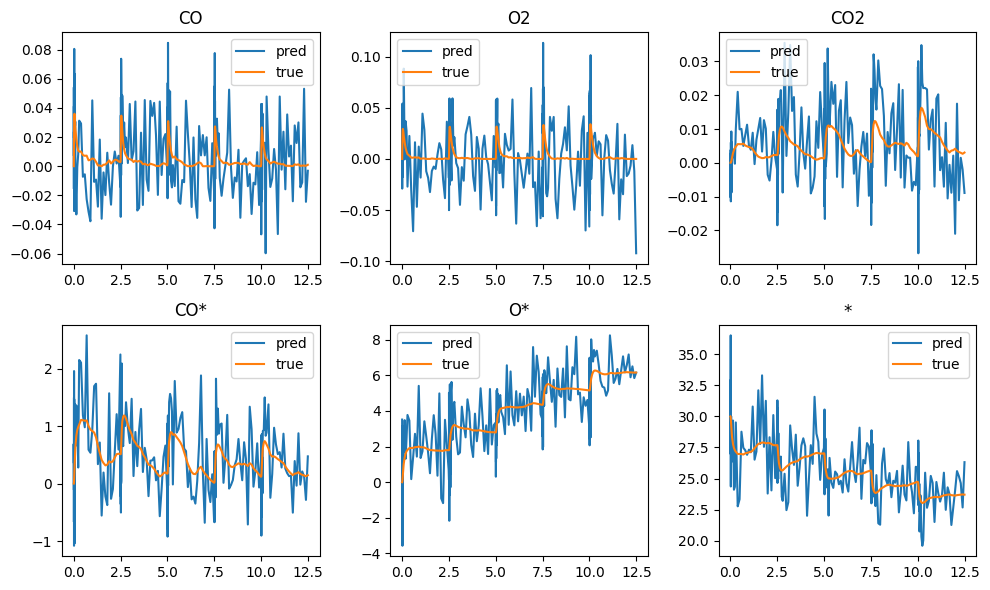

In [572]:
t_plot  = list(instance.t)

data_plot = {}

data_plot['CO']  = [value(instance.CO[i]) for i in t_plot]
data_plot['O2']  = [value(instance.O2[i]) for i in t_plot]
data_plot['CO2'] = [value(instance.CO2[i]) for i in t_plot]

data_plot['CO*'] = [value(instance.COs[i]) for i in t_plot]
data_plot['O*']  = [value(instance.Os[i]) for i in t_plot]
data_plot['*']   = [value(instance.s[i]) for i in t_plot]

fig, axs = plt.subplots(2, 3, figsize=(10,6), tight_layout=True)
j=0
for i, key in enumerate(data_plot):
    lists = sorted(data[j].items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    axs[i//3,i%3].plot(x, y)
    axs[i//3,i%3].plot(t_plot, data_plot[key])
    axs[i//3,i%3].set_title(key)
    axs[i//3,i%3].legend(['pred','true'])
    j=j+1

In [573]:
instance.k1.pprint()
instance.k1_.pprint()
instance.k2.pprint()
instance.k3.pprint()
instance.k3_.pprint()
instance.k4.pprint()

k1 : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :     0 : 9.647215486780393 :  None : False : False : PositiveReals
k1_ : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 1.7798112072724206 :  None : False : False : PositiveReals
k2 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 0.3097826863345813 :  None : False : False : PositiveReals
k3 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 111887.70056875666 :  None : False : False : PositiveReals
k3_ : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :     0 : 58943.07819694284 :  None : False : False : PositiveReals
k4 : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :     0 : 32.01260523890931 :  Non

Text(0, 0.5, '$log_{10}(k_{NN})$')

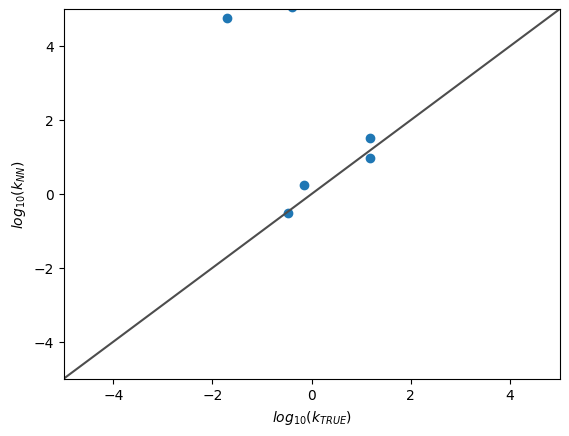

In [574]:
model_params_true = np.array([15, 0.7, 0.33, 0.4, 0.02, 15.2])
model_params_fit = [value(instance.k1), value(instance.k1_), value(instance.k2), value(instance.k3),
                   value(instance.k3_), value(instance.k4)]


f, ax = plt.subplots()

ax.scatter(np.log10(model_params_true), np.log10(model_params_fit))
ax.set(xlim=(-5, 5), ylim=(-5, 5))
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c = '.3')
ax.set_xlabel('$log_{10}(k_{TRUE})$')
ax.set_ylabel('$log_{10}(k_{NN})$')

In [575]:
data_plot['time'] = t_plot
data_plot['k'] = model_params_fit

pd.DataFrame.from_dict(data_plot, orient='index').transpose().to_csv('20_dae_unsmooth.csv')
pd.DataFrame.from_dict(data, orient='index').transpose().to_csv('20_raw_unsmooth.csv')

## Uncertainty Estimation with Reduced Hessian

In [230]:
import pyomo.contrib.interior_point.inverse_reduced_hessian as inverse_reduced_hessian
(   solve_result,
    inv_red_hes,
) = inverse_reduced_hessian.inv_reduced_hessian_barrier(
    instance,
    independent_variables=[instance.k1,instance.k1_,instance.k2,instance.k3,instance.k3_,instance.k4],
    tee=True,
)

Ipopt 3.14.12: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    48190
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    15859

Total number of variables............................:     9525
                     variables with only lower bounds:     3816
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality const

  78  9.5867598e+02 6.37e-01 9.80e+03  -5.7 1.06e+04    -  2.51e-03 2.50e-01f  3
  79  9.5867597e+02 1.05e-01 4.50e+03  -5.7 1.34e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  9.5867596e+02 2.28e-05 2.96e-01  -5.7 3.93e-01  -8.2 1.00e+00 1.00e+00h  1
  81  9.5867596e+02 3.69e-01 6.04e+01  -5.7 1.80e+04    -  2.94e-01 1.49e-01h  2
  82  9.5867595e+02 2.11e-01 2.01e+01  -5.7 5.27e+03    -  1.00e+00 1.00e+00h  1
  83  9.5867595e+02 1.80e-01 2.67e+01  -5.7 6.61e+03    -  1.00e+00 1.00e+00h  1
  84  9.5867595e+02 8.42e-03 8.13e-01  -5.7 1.46e+03    -  1.00e+00 1.00e+00h  1
  85  9.5867595e+02 1.90e-08 1.82e-06  -5.7 5.44e-02  -8.7 1.00e+00 1.00e+00h  1
  86  9.5867570e+02 2.41e-03 3.74e+01  -8.6 1.02e+00  -9.1 9.94e-01 9.00e-01f  1
  87  9.5867567e+02 2.26e-04 2.49e+00  -8.6 5.63e-01  -9.6 1.00e+00 9.44e-01h  1
  88  9.5867567e+02 1.33e-05 4.11e-04  -8.6 1.82e+00 -10.1 1.00e+00 1.00e+00f  1
  89  9.5867567e+02 2.48e-07

 171  9.5867567e+02 1.21e-05 1.70e-05  -9.0 6.25e+01 -13.1 1.00e+00 1.00e+00H  1
 172  9.5867567e+02 1.24e-05 2.44e-05  -9.0 1.24e+02 -13.6 1.00e+00 1.00e+00H  1
 173  9.5867567e+02 1.88e-07 7.82e-05  -9.0 2.73e+02    -  1.00e+00 1.00e+00H  1
 174  9.5867567e+02 1.83e-07 2.83e-04  -9.0 5.19e+02    -  1.00e+00 1.00e+00H  1
 175  9.5867567e+02 5.56e-06 6.39e-06  -9.0 2.63e+01 -12.7 1.00e+00 1.00e+00h  1
 176  9.5867567e+02 6.41e-05 9.99e-05  -9.0 1.03e+02    -  1.00e+00 1.00e+00h  1
 177  9.5867567e+02 4.51e-05 4.03e-04  -9.0 7.75e+01 -13.2 1.00e+00 2.50e-01h  3
 178  9.5867567e+02 4.51e-05 2.03e-04  -9.0 2.97e+01 -12.8 1.00e+00 9.77e-04h 11
 179  9.5867567e+02 1.65e-03 5.06e-03  -9.0 7.36e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  9.5867567e+02 6.48e-02 3.64e-01  -9.0 6.29e+03    -  1.00e+00 1.00e+00h  1
 181  9.5867567e+02 6.19e-04 1.86e-04  -9.0 7.82e+01 -13.2 1.00e+00 1.00e+00h  1
 182  9.5867567e+02 6.54e-05

In [231]:
objval = value(instance.obj)
sse=objval
n=635
l=6
cov = 2 * sse / (n - l) * inv_red_hes
print(cov)

[[ 9.58396542e+01  5.76239344e+00 -1.74320983e-04 -6.36947530e+04
  -2.71100207e+04 -5.71898402e+02]
 [ 5.76239344e+00  1.21043535e+01 -4.87891241e-04 -8.86872166e+05
  -3.67895868e+05  3.53278360e+01]
 [-1.74320981e-04 -4.87891225e-04  3.70226373e-03  4.72369836e+00
   6.54145839e+00 -8.36383978e-04]
 [-6.36819955e+04 -8.86870911e+05  4.09694397e+00 -3.55341394e+16
  -1.46960820e+16 -6.44773231e+06]
 [-2.71047445e+04 -3.67895349e+05  6.28224767e+00 -1.46960820e+16
  -6.07795207e+15 -2.66519266e+06]
 [-5.71898402e+02  3.53278361e+01 -8.36384116e-04 -6.44668746e+06
  -2.66484753e+06  5.63556938e+03]]


In [65]:
# Fisher information matrix can be computed using the inverse of the reduced Hessian
fim = np.linalg.inv(cov)
theta_names=['k1','k1_','k2','k3','k3_','k4']
# Eigen decomposition of the Fisher information matrix
eig_values, eig_vectors = np.linalg.eig(fim)

for i,eig in enumerate(eig_values):
    print('***************************************************************')
    print('\nEigen value: {:0.3e}\n'.format(eig))
    print('=== Eigen vector elements with correspondng parameter names ===\n')
    print('------------------------------')
    print('| Vector element | Parameter |')
    print('------------------------------')
    for j,theta_name in enumerate(theta_names):
        if eig_vectors[i,j] < 0.0:
            print('|   {:0.3e}   |    {}     |'.format(eig_vectors[i,j],theta_name))
        else:
            print('|   {:0.3e}    |    {}     |'.format(eig_vectors[i,j],theta_name))
    print('\n')


***************************************************************

Eigen value: 7.128e+02

=== Eigen vector elements with correspondng parameter names ===

------------------------------
| Vector element | Parameter |
------------------------------
|   4.442e-05    |    k1     |
|   -3.972e-03   |    k1_     |
|   -2.345e-01   |    k2     |
|   -9.653e-01   |    k3     |
|   1.068e-01    |    k3_     |
|   4.113e-02    |    k4     |


***************************************************************

Eigen value: 1.155e+02

=== Eigen vector elements with correspondng parameter names ===

------------------------------
| Vector element | Parameter |
------------------------------
|   -6.474e-05   |    k1     |
|   8.895e-03    |    k1_     |
|   9.717e-01    |    k2     |
|   -2.360e-01   |    k3     |
|   -3.387e-03   |    k3_     |
|   9.480e-03    |    k4     |


***************************************************************

Eigen value: 1.021e+00

=== Eigen vector elements with corres

In [232]:
np.sqrt(np.diag(cov))

/tmp/ipykernel_886122/4001918971.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(np.diag(cov))


array([9.78977294e+00, 3.47913114e+00, 6.08462302e-02,            nan,
                  nan, 7.50704295e+01])